<a href="https://colab.research.google.com/github/asrjy/machine-learning/blob/main/09%20Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## WTH is Regularization?

- Penalizes memorization (overlearning examples)
- Helps model generalize to unseen examples
- Changes representation of learning either by making it more sparse or more distributed, depending on the regulizer. 
- Can increase or decrease the learning time. 
- Can decrease training accuracy but increase generalization. 
- Tends to work for models with large number of layers
and for models with sufficient data. 

- Three families of regulizers
  1. Modify the model (dropout)
  2. Add a cost to the loss function (L1/L2)
  3. Modify or add data (batch training, data augmentation)

- Dropout: Remove nodes randoml during learning (force activation = 0)

- Forces the solution to be smooth
- Adds a cost to the complexity of the solution
- Prevents model from learning item specific details. 

## Training vs Evaluation mode

- Gradients are computed only during backpropogation (training), not during evaluation
- Some regularization methods are to be applied only during training phase (like dropout and batch normalization) not during evaluation phase. 
- Hence we need to be able to activate regularization and gradient computations on demand during training and evaluation. 
- Three methods to help with this:
  1. net.train() - Turned on by default. Only needs to be turned on when explicitly turned off with net.eval(). Regularization is active in this mode. 
  2. net.eval() - Only necessary when we are evaluating models which contain regularization like dropout or batch normalization. 
  3. torch.no_grad() - Gradients are not computed. Usually never necessary. Makes large models evaluate faster by turning off unnecessary computations. 

    ```
    training each loop:
      net.train()
      # train the model
      batch loop:

      # evaluate the model
      net.eval()
      with torch.no_grad():
        yHat = net(x)
    ```
- In dropout included model's training phase, each neuron is dropped with a probability p. But during test phase, no neuron are dropped. But as a result of dropping, the weights of the neurons are going to be affected. So we multiply weights with (1-p). Alternative method is to multiply weights with q, where q = 1/(1-p). We are scaling up when we multiply with q, scaling down when we multiply with 1-p. 
- PyTorch implements the second method by default. 
- Dropout prevents a single node from learning too much and forces model to have distributed representations. Makes the model less reliant on individual nodes, thus making it more stable. 
- Generally requires more training, though each epoch is computed faster. 
- Implementation of dropout on convolutional layers is debatable. 


## Dropout in PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
prob = .5
dropout = nn.Dropout(p=prob)
x = torch.ones(10)
print(x)
y = dropout(x)
print(y)
print(y*(1-prob))
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 0., 2., 2., 0., 0., 0., 2., 0., 0.])
tensor([0., 0., 1., 1., 0., 0., 0., 1., 0., 0.])
tensor(0.6000)


In [ ]:
# Dropout is turned off in eval mode
dropout.eval()
x = torch.ones(10)
y = dropout(x)
print(x)
print(y)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [ ]:
# But Dropout in nn.Functional is not deactivated automatically
dropout.eval()
x = torch.ones(10)
y = F.dropout(x)
print(x)
print(y)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 0., 0., 0., 2., 2., 0., 2., 2., 2.])


In [ ]:
# But it can be manually switched off
x = torch.ones(10)
y = F.dropout(x, training=False)
print(x)
print(y)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [ ]:
# The model needs to be reset back to training mode, if eval mode is turned on
dropout.train()
y = dropout(x)
print(y)

dropout.eval()
y = dropout(x)
print(y)

dropout.train()
y = dropout(x)
print(y)

tensor([2., 2., 0., 2., 0., 2., 2., 0., 2., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 2., 2., 2., 0., 2., 0., 0., 2., 2.])


## Dropout in Practice

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display 
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

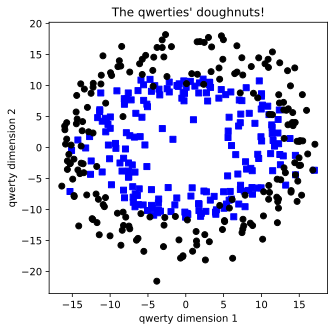

In [2]:
# Create Data

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 16
train_loader = DataLoader(train_data, shuffle=True, batch_size = batch_size)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [4]:
class theModelClass(nn.Module):
  def __init__(self, dropoutRate):
    super().__init__()
    # Layer Initialization
    self.input = nn.Linear(2, 128)
    self.hidden = nn.Linear(128, 128)
    self.output = nn.Linear(128, 1)
    # Parameters
    self.dr = dropoutRate
  def forward(self, x):
    x = F.relu(self.input(x))
    # Dropout after the input layer
    x = F.dropout(x, p = self.dr, training = self.training)
    # self.training means True if model is in training mode, False if model is in eval mode. No need to manually mention True/False
    x = F.relu(self.hidden(x))
    x = F.dropout(x, p = self.dr, training = self.training)
    x = self.output(x)
    return x

In [5]:
tmpnet = theModelClass(.25)
tmpdata = torch.randn((10, 2))
yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.0138],
        [ 0.0671],
        [ 0.1373],
        [ 0.1829],
        [-0.0272],
        [ 0.2371],
        [-0.0134],
        [ 0.1634],
        [ 0.4521],
        [ 0.4648]], grad_fn=<AddmmBackward0>)

In [6]:
def createNewModel(dropoutrate):
  ANNQc = theModelClass(dropoutrate)
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(ANNQc.parameters(), lr = .002)
  return ANNQc, lossfun, optimizer

In [7]:
nepochs = 1000

def trainModel(ANNQc, lossfun, optimizer):
  train_acc = []
  eval_acc = []
  for epoch in range(nepochs):
    batch_acc = []
    for X, y in train_loader:
      yHat = ANNQc(X)
      loss = lossfun(yHat, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batch_acc.append(100 * torch.mean(((yHat > .5) == y).float()).item())
    train_acc.append(np.mean(batch_acc))
    ANNQc.eval()
    X, y = next(iter(test_loader))
    yHat = ANNQc(X)
    eval_acc.append(100 * torch.mean(((yHat > .5) == y).float()).item())
    ANNQc.train()
  return train_acc, eval_acc

In [8]:
dropoutrate = 0
ANNQc, lossfun, optimizer = createNewModel(dropoutrate)
train_acc, eval_acc = trainModel(ANNQc, lossfun, optimizer)

In [9]:
def smooth(x, k = 5):
  return np.convolve(x, np.ones(k)/k, mode = 'same')

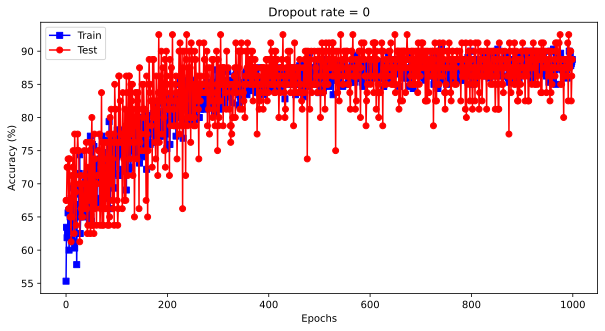

In [11]:
fig = plt.figure(figsize=(10,5))

plt.plot(train_acc,'bs-')
plt.plot(eval_acc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

The graph does not look that smooth because of batches. More on this, later. 

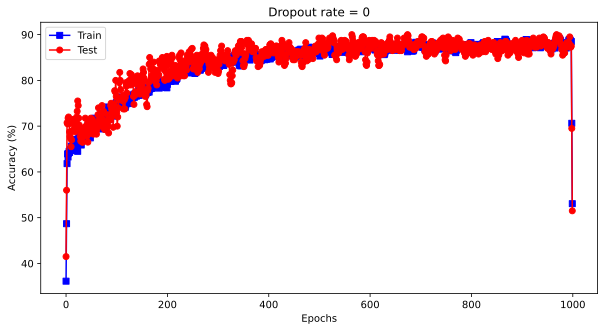

In [12]:
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(train_acc),'bs-')
plt.plot(smooth(eval_acc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

In [13]:
dropoutrates = np.arange(10)/10
results = np.zeros((len(dropoutrates), 2))

for di in range(len(dropoutrates)):
  ANNQc, lossfun, optimizer = createNewModel(dropoutrates[di])
  train_acc, eval_acc = trainModel(ANNQc, lossfun, optimizer)

  results[di, 0] = np.mean(train_acc[-100:])
  results[di, 1] = np.mean(eval_acc[-100:])

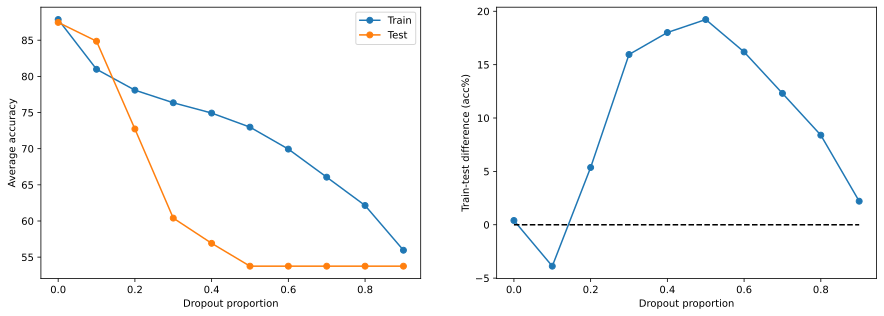

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(dropoutrates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutrates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

Least dropout rates gave the best performance, on this dataset

## Dropout Example 2

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import matplotlib.pyplot as plt
from IPython import display 
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [18]:
import seaborn as sns 

iris = sns.load_dataset('iris')

data = torch.tensor(iris[iris.columns[:4]].values).float()

labels = torch.zeros(len(data), dtype = torch.long)
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

In [19]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchsize = 16
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [22]:
class modelClass(nn.Module):
  def __init__(self, dropoutrate):
    super().__init__()
    self.input = nn.Linear(4, 12)
    self.hidden = nn.Linear(12, 12)
    self.output = nn.Linear(12, 3)
    self.dr = dropoutrate
  def forward(self, x):
    x = F.relu(self.input(x))
    x = F.dropout(x, p = self.dr, training = self.training)
    x = F.relu(self.hidden(x))
    x = F.dropout(x, p = self.dr, training = self.training)
    x = self.output(x)
    return x

In [23]:
tmpnet = modelClass(.25)
tmpdata = torch.randn((10, 4))
yhat = tmpnet(tmpdata)
yhat

tensor([[-4.3824e-01,  3.6677e-02, -1.5959e-01],
        [-3.6391e-01,  2.0382e-01, -2.2613e-01],
        [-1.1643e-01, -5.7907e-03, -8.8469e-02],
        [-1.4463e-01, -4.4217e-03, -3.0894e-01],
        [-4.7382e-02,  3.7040e-02, -8.1300e-02],
        [-1.3002e-01,  2.7046e-03, -2.6855e-01],
        [-4.7438e-01,  7.0380e-03, -3.2496e-01],
        [-1.3370e-01,  5.1390e-02,  4.1480e-04],
        [ 4.5239e-03,  1.0691e-02, -9.7276e-02],
        [-1.5159e-01, -2.0360e-01, -3.5588e-01]], grad_fn=<AddmmBackward0>)

In [27]:
def createNewModel(dropoutrate):
  ANNiris = modelClass(dropoutrate)
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params = ANNiris.parameters(), lr=.005)
  return ANNiris, lossfun, optimizer

In [31]:
numepochs = 500
def trainModel():
  train_acc = []
  eval_acc = []

  for epochi in range(numepochs):
    batch_acc = []
    for X, y in train_loader:
      yHat = ANNiris(X)
      loss = lossfun(yHat, y)
      batch_acc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) -- y).float()).item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    train_acc.append(np.mean(batch_acc))
    ANNiris.eval()
    X, y = next(iter(test_loader))
    predlabels = torch.argmax(ANNiris(X), axis = 1)
    eval_acc.append(100 * torch.mean((predlabels == y).float()).item())
    ANNiris.train()
  return train_acc, eval_acc

In [32]:
dropoutrate = 0
ANNiris, lossfun, optimizer = createNewModel(dropoutrate)
train_acc, eval_acc = trainModel()

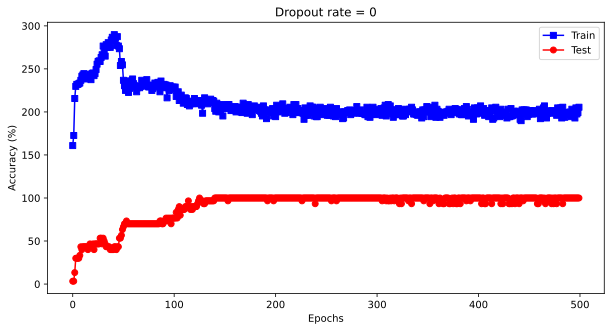

In [34]:
fig = plt.figure(figsize=(10,5))

plt.plot(train_acc,'bs-')
plt.plot(eval_acc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

In [35]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # create and train the model
  ANNiris,lossfun,optimizer = createNewModel(dropoutRates[di])
  trainAcc,testAcc = trainModel()

  # store accuracies
  results[di,0] = np.mean(trainAcc[-50:])
  results[di,1] = np.mean(testAcc[-50:])

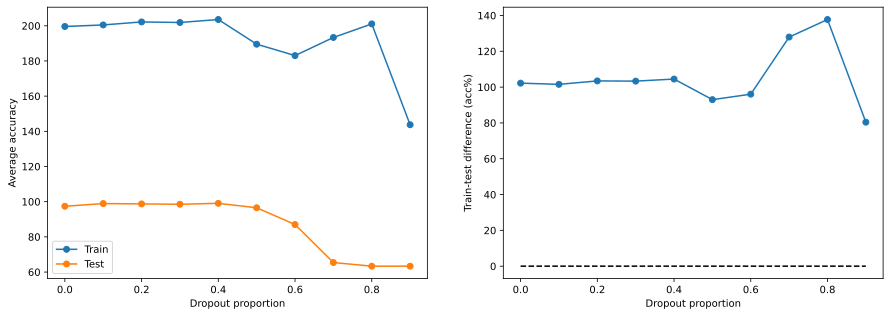

In [36]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

## Weight Regularization (L1/L2)

With the addition of regularization term, model will not only work towards minimizing loss, but also the regualization term. 

lambda = regularization term. something small like .001

L2 Regularization shrinks all weights. It has diminishing returns. 

L1 Regularization creates sparse weights by setting some to 0.

We want the loss to be relatively larger than the regularization. 

Lambda usually taken as alpha/2m where alpha is usually = .01 and m = number of weights. 

L1 + L2 = elastic net regression


Regularization discourages complex and sample specific representations. 

Prevents overfitting to training examples. 

Large weights lead to instability. 

Use Regularization when we have large, complex models with lots of weights. Use L1 when trying to understand the important encoding features (common in regression than deep learning). When training accuracy is much higher than validation accuracy. 

## L2 Regularization in practice

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

In [2]:
iris = sns.load_dataset('iris')

In [3]:
data = torch.tensor(iris[iris.columns[:4]].values).float()

labels = torch.zeros(len(data), dtype = torch.long)
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

In [38]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, shuffle = True, batch_size = 64, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size = test_dataset.tensors[0].shape[0])
                             

In [39]:
def createModel(L2lambda):
  ANNiris = nn.Sequential(
      nn.Linear(4, 64),
      nn.ReLU(),
      nn.Linear(64, 64),
      nn.ReLU(),
      nn.Linear(64, 3)
  )
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params = ANNiris.parameters(), lr = .005, weight_decay = L2lambda)
  return ANNiris, lossfun, optimizer

In [44]:
numepochs = 1000
def trainModel():
  train_acc = []
  eval_acc = []
  losses = []
  for e in range(numepochs):
    batch_acc = []
    batch_loss = []
    for X, y in train_loader:
      yHat = ANNiris(X)
      loss = lossfun(yHat, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batch_acc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item())
      batch_loss.append(loss.item())
    train_acc.append(np.mean(batch_acc))
    losses.append(np.mean(batch_loss))
    ANNiris.eval()
    X, y = next(iter(test_loader))
    preds = torch.argmax(ANNiris(X), axis = 1) == y
    eval_acc.append(100 * torch.mean(preds.float()).item())
    ANNiris.train()
  return train_acc, eval_acc, losses

In [45]:
L2lambda = .01
ANNiris, lossfun, optimizer = createModel(L2lambda)
train_acc, eval_acc, losses = trainModel()

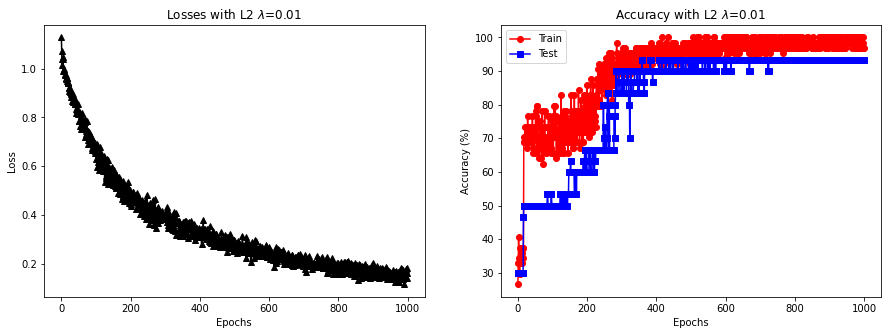

In [47]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))

ax[1].plot(train_acc,'ro-')
ax[1].plot(eval_acc,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [48]:
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

In [49]:
l2lambdas = np.linspace(0,.1,10)

accuracyResultsTrain = np.zeros((numepochs,len(l2lambdas)))
accuracyResultsTest  = np.zeros((numepochs,len(l2lambdas)))


for li in range(len(l2lambdas)):
  ANNiris,lossfun,optimizer = createModel(l2lambdas[li])
  trainAcc,testAcc,losses = trainModel()
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li]  = smooth(testAcc,10)

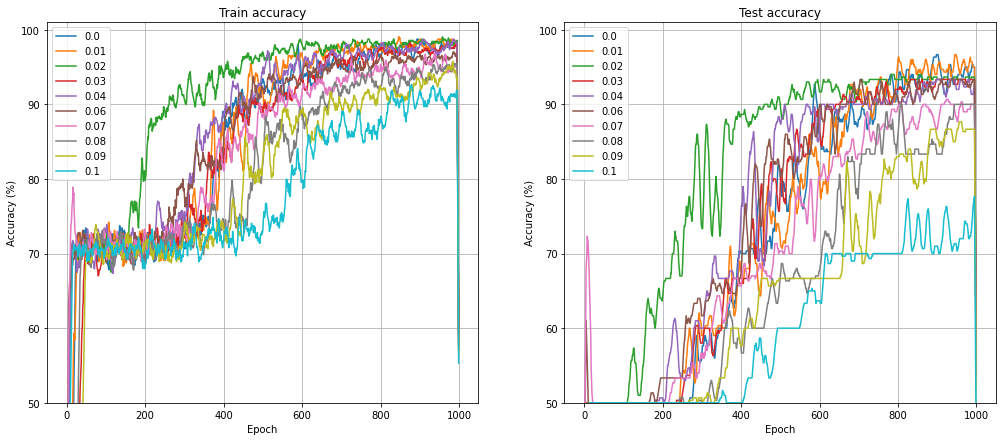

In [50]:
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')
leglabels = [np.round(i,2) for i in l2lambdas]
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

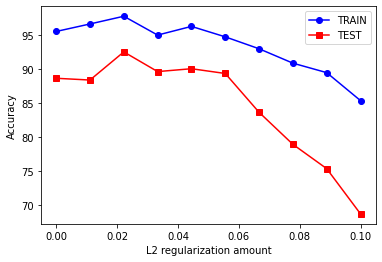

In [51]:
epoch_range = [500,950]


plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## L1 Regularization in practice